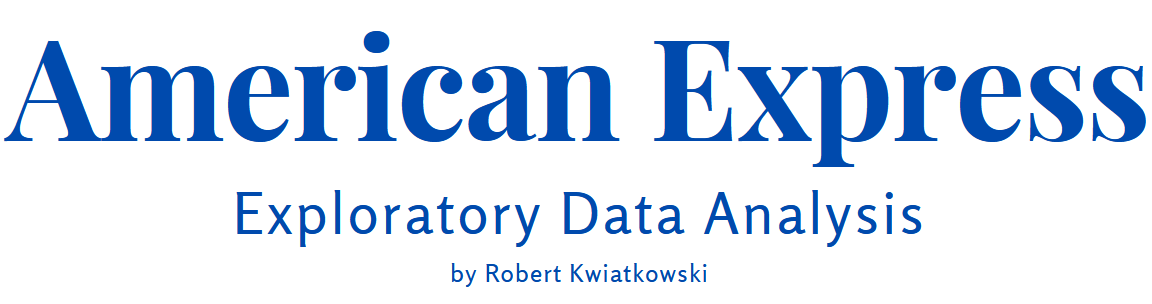

# <b>1. Introduction</b>

American Express Company (called also Amex) is a multinational corporation with a sepcialisation in payment cards. It is present on the New York Stock Exchange (NYSE) with a ticker AXP. New York is also a city where they have the headquarter. They employ over 63k employees worldwide and hold about 23% payment card market in US.

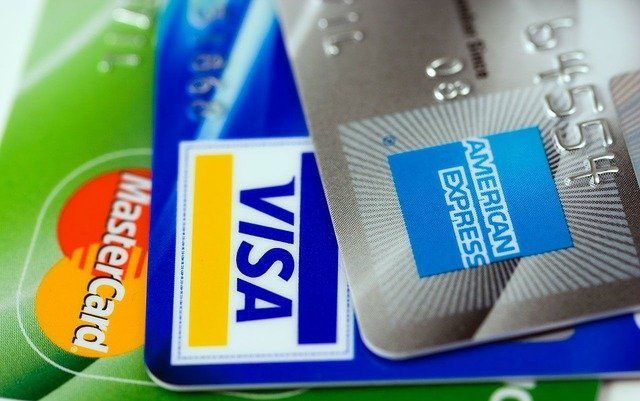

As for many banks the core of its operation is crediting, it's crucial to manage it efficiently. Especially banks want to lend money only to people who can pay the loan. That's why in this chalange we are asked to find out which customers are not able to do it. Not paying the money back is called `default`. This notebook explores the American Express (AMEX) churn prediction dataset.  

Here's a nice [McKinsely's article](https://www.mckinsey.com/industries/technology-media-and-telecommunications/our-insights/grow-fast-or-die-slow-focusing-on-customer-success-to-drive-growth) about the impact of churn on businesses.

Some other useful resources:
* [Predict Customer Churn in Python (Towards Data Science)](https://towardsdatascience.com/predict-customer-churn-in-python-e8cd6d3aaa7)
* [Churn Prediction- Commercial use of Data Science (Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/08/churn-prediction-commercial-use-of-data-science/)
* [Can You Predict Customer Churn ? (Youtube)](https://www.youtube.com/watch?v=ocMd2loRfWE)

In this competition the evaluation metric is referenced in [this notebook](https://www.kaggle.com/code/inversion/amex-competition-metric-python). It uses two submetrics where one is a normalized Gini coefficient, a good and clean explanation of this metrics can be found [here](https://theblog.github.io/post/gini-coefficient-intuitive-explanation/).

# <b>2. Reading libraries</b>

In [ ]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import math
import gc
import pprint

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# <b> 3. Reading data </b>

Because this dataset is huge and reading it directly from the .csv file consumes almost the entire memory we have to find a workaround. There are essentialy two options:
* Read data chunk by chunk
* Used a compressed dataset

In [ ]:
TRAIN_DATA_PATH = "../input/amex-default-prediction/train_data.csv"

# <b> 3.1 Reading in chunks </b>

In [ ]:
chunksize = 13000
df_train_raw_chunks = pd.read_csv(TRAIN_DATA_PATH, chunksize=chunksize)

Everytime you run the cell below you'll get a new chunk.

In [ ]:
df_train_raw_ch = df_train_raw_chunks.__next__()
df_train_raw_ch.head()

Now, we can do with this chunk all what we want. For example subsample a chunk only to data of a single customer.

In [ ]:
sample_customer_id = np.random.choice(df_train_raw_ch['customer_ID'])
customer_data_ex = df_train_raw_ch[df_train_raw_ch["customer_ID"] == sample_customer_id]
customer_data_ex.head()

As this method is somehow usefull for EDA it desn't allow you to explore the entire distribution of data and thus the second option is preffered. So let's clean the memory.

In [ ]:
del df_train_raw_chunks, df_train_raw_ch, customer_data_ex, sample_customer_id
gc.collect()

# <b> 3.2 Reading a compressed dataset </b>

There is an pre-processed, lightweight version of this dataset (train data already merged with labels): [AMEX-Feather-Dataset](https://www.kaggle.com/datasets/munumbutt/amexfeather) (thank you [Munum](https://www.kaggle.com/munumbutt)!). This dataset is available in Apache's feather format (more about it you can read [here](https://arrow.apache.org/docs/python/feather.html)). There is also a parquet version ([Amex Competition Data in Parquet Format](https://www.kaggle.com/datasets/odins0n/amex-parquet)).  

However, the one I suggest to use [is this one](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format), which is already precleaned by [raddar](https://www.kaggle.com/raddar) from the artificial noise.

Before you can use it, you have to add it to your environment by clicking **"+ Add data"** button in the upper right corner of Kaggle's interface. 

In [ ]:
train_raw = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet')

In [ ]:
labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')

In [ ]:
labels.head()

In [ ]:
train_raw = train_raw.merge(labels, left_on='customer_ID', right_on='customer_ID')

In [ ]:
train_raw.shape

# <b> 4. EDA </b>

Columns in the dataset are divided by the organisers in the following groups:  
**`D_*`:** Delinquency variables  
**`S_*`:** Spend variables  
**`P_*`:** Payment variables  
**`B_*`:** Balance variables  
**`R_*`:** Risk variables  
Following features are categorical: `B_30`, `B_38`, `D_63`, `D_64`, `D_66`, `D_68`, `D_114`, `D_116`, `D_117`, `D_120`, `D_126`.

**`S_2`:** contains a timestamp

In [ ]:
train_raw['S_2'] = pd.to_datetime(train_raw['S_2'])

In [ ]:
categorical_features = ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']
train_raw[categorical_features] = train_raw[categorical_features].astype("category")
train_raw[categorical_features].dtypes

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)

data = train_raw
df_dtypes = train_raw.dtypes.value_counts()

fig = plt.figure(figsize=(5,2),facecolor='white')

ax = fig.add_subplot(1,1,1)
font = 'monospace'
ax.text(1, 0.8, "Key figures",color='black',fontsize=28, fontweight='bold', fontfamily=font, ha='center')

ax.text(0, 0.4, "{:,d}".format(data.shape[0]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(0, 0.001, "# of rows \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.text(0.6, 0.4, "{}".format(data.shape[1]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(0.6, 0.001, "# of features \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.text(1.2, 0.4, "{}".format(len(data.select_dtypes(np.number).columns)), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(1.2, 0.001, "# of numeric columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font, ha='center')

ax.text(1.9, 0.4,"{}".format(len(data.select_dtypes('datetime').columns)), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(1.9, 0.001,"# of datetime columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.set_yticklabels('')
ax.tick_params(axis='y',length=0)
ax.tick_params(axis='x',length=0)
ax.set_xticklabels('')

for direction in ['top','right','left','bottom']:
    ax.spines[direction].set_visible(False)

fig.subplots_adjust(top=0.9, bottom=0.2, left=0, hspace=1)

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#346eeb')
fig.patch.set_facecolor('#f6f6f6')
ax.set_facecolor('#f6f6f6')
    
plt.show()

Let's check now what are the date ranges in our database.

In [ ]:
print(f'Train dates range is from {train_raw["S_2"].min()} to {train_raw["S_2"].max()}.')

We have slightly over one year of data.

# <b> 3.1 Missing data </b>

Let's see now how many missing values do we have.

In [ ]:
tmp = train_raw.isna().sum().div(len(train_raw)).mul(100).sort_values(ascending=False)

In [ ]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots(2,1, figsize=(25,10))
sns.barplot(x=tmp[:100].index, y=tmp[:100].values, ax=ax[0])
sns.barplot(x=tmp[100:].index, y=tmp[100:].values, ax=ax[1])
ax[0].set_ylabel("Percentage [%]"), ax[1].set_ylabel("Percentage [%]")
ax[0].tick_params(axis='x', rotation=90); ax[1].tick_params(axis='x', rotation=90)
plt.suptitle("Amount of missing data")
plt.tight_layout()
plt.show()

There is a significant number of features with a lot of missing data.

# <b> 3.2 Distribution of a target variable </b>

Let's check now the distribution of the `target` variable.

In [ ]:
tmp = train_raw['target'].value_counts().div(len(train_raw)).mul(100)

In [ ]:
ax = sns.barplot(x=tmp.index, y=tmp.values)
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.title("Distribution of a target variable")
plt.ylabel("Percentage [%]")
plt.show()

It's clear that our dataset is unbalanced and this is a crucial point to keep in mind while modelling. 25% of customers had a default - it will be worth investigating these two groups separately to find some differences. First let's see how many unique customers do we have.

In [ ]:
print(f'Number of unique customers: {train_raw["customer_ID"].nunique()}')

# <b> 3.3 Customers presence </b>

We have about 459 000 unique customers.

In [ ]:
cust_presence = train_raw.groupby(['customer_ID','target']).size().reset_index().rename(columns={0:'presence'})
cust_presence.head()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(x='presence', data=cust_presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
ax.bar_label(ax.containers[0], fmt='%.f%%')
ax.bar_label(ax.containers[1], fmt='%.f%%')
plt.show()

The plot above shows how long are customer present in a dataset. It shows that 93% of them are visible for the entire full year. It's difficult from this graph to see how targets are distributed for the remaining customers, so let's zoom.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(x='presence', data=cust_presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
ax.bar_label(ax.containers[0], fmt='%.2f%%')
ax.bar_label(ax.containers[1], fmt='%.2f%%')
ax.set_xlim(0,12)
ax.set_ylim(0,1)
plt.show()

Now it's clear that customers who are for a short time in a database are more prone to churn. We can add now this information as an additional feature if we want.
During a discussion [here](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327597#1809185) there was a question who are customers with less than 13 observations. Let's investigate this.

In [ ]:
short_customer_ids = list(cust_presence[cust_presence['presence']<13]['customer_ID'])
gc.collect()

In [ ]:
short_customers = train_raw[train_raw['customer_ID'].isin(short_customer_ids)][['customer_ID','S_2']]
short_customers['month'] = short_customers['S_2'].dt.month
short_customers['year'] = short_customers['S_2'].dt.year
short_customers.groupby(['year','month']).size()

In [ ]:
len(short_customers)

If all "short" customers are only there due to late entry then all with the same presence number would be in the same month.

In [ ]:
n=2
short_customer_ids_n = list(cust_presence[cust_presence['presence']<=n]['customer_ID'])

short_customers = train_raw[train_raw['customer_ID'].isin(short_customer_ids_n)][['customer_ID','S_2']]
short_customers['month'] = short_customers['S_2'].dt.month
short_customers['year'] = short_customers['S_2'].dt.year
print(f"Customers with presence equal to {n} observations.")
print(short_customers.groupby(['year','month']).size())

In [ ]:
len(short_customers)

Now, it's clear that short customers are also these who dropped from the observation period as well. Let's see now data for an exemplary customer from this subsample.

In [ ]:
cust_2obs_03_2017 = list(short_customers.loc[(short_customers['year']==2017)&(short_customers['month']==3),'customer_ID'])

In [ ]:
sample_customer = np.random.choice(cust_2obs_03_2017)
train_raw[train_raw["customer_ID"]==sample_customer].head()

# <b> 3.4 Correlations </b>

Before we dive in into distributions of the individual features let's check are there any highly correlated ones. Because it would take ags to calculate the entire correlation matrix I'll use an approximate method by using a sample of 25% of customers.

In [ ]:
def sample_full_cust(df, cust_ratio):
    n_customers = df['customer_ID'].nunique()
    no_of_cust = int(n_customers*cust_ratio)
    cust_ids = np.random.choice(df['customer_ID'].unique(), no_of_cust)
    print(f'Number of customers sampled: {no_of_cust}')
    ready_df = df[df['customer_ID'].isin(cust_ids)]
    print(f'Number of rows sampled: {len(ready_df)} ({round(len(ready_df)/len(df)*100)}%)')
    return ready_df

In [ ]:
train_samples = sample_full_cust(train_raw, 0.55)

In [ ]:
correlations = train_samples.corr().abs()

In [ ]:
mask=np.triu(np.ones_like(correlations))

fig, ax = plt.subplots(1,1, figsize=(16,12))
sns.heatmap(correlations, ax=ax, mask=mask, cmap='YlOrBr')
ax.set_title("Correlation of features")
plt.show()

The graph above shows us that most of features is not correlated but there are visible dark 'pixels' meaning we have some highly-correlated ones. In order to print them from the most correlated to the least we have to unstack the results.

In [ ]:
unstacked = correlations.unstack()
unstacked = unstacked.sort_values(ascending=False, kind="quicksort").drop_duplicates().head(25)
unstacked

Indeed we have a lot of highly correlated features. Worth keeping this in mind!
Let's plot a correlated features to visualise them. Because at each run the sample is different results may vary a bit.

In [ ]:
x1, y1 = unstacked.index[1]
x2, y2 = unstacked.index[2]
x3, y3 = unstacked.index[3]

fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.scatterplot(x=x1, y=y1, data=train_samples, hue='target', ax=ax[0])
sns.scatterplot(x=x2, y=y2, data=train_samples, hue='target', ax=ax[1])
sns.scatterplot(x=x3, y=y3, data=train_samples, hue='target', ax=ax[2])
plt.show()

The plot at the beggining of this chapter may be a bit unclear if we are interested more in details. Therefore it would be better to look at the correlations on the level of each column group. As this matrix is symmetrical we can take only one side of it.

In [ ]:
# code adapted from: https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
cols_to_show = [c for c in train_samples.columns if (c.startswith('R'))]
corr=train_samples[cols_to_show].corr()
mask=np.triu(np.ones_like(corr))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()

fig, ax = plt.subplots(figsize=(30,30))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Risk Variables\n', fontsize=16)
plt.show()

In [ ]:
# code adapted from: https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline
cols_to_show = [c for c in train_samples.columns if (c.startswith('S'))]
corr=train_samples[cols_to_show].corr()
mask=np.triu(np.ones_like(corr))[1:,:-1]
corr=corr.iloc[1:,:-1].copy()

fig, ax = plt.subplots(figsize=(15,15))   
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
            cmap='coolwarm', annot_kws={'fontsize':10,'fontweight':'bold'}, cbar=False)
ax.tick_params(left=False,bottom=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.title('Correlations between Spend Variables\n', fontsize=16)
plt.show()

# <b> 3.5 Categorical features </b>

We are given by the organizers a list of categorical features. Let's take a quick look at them.

In [ ]:
train_raw[categorical_features].sample(10)

What are the unique values per categorical column?

In [ ]:
for cf in categorical_features:
    print(cf, list(train_raw[cf].unique()))

How many missing values ber category?

In [ ]:
train_raw[categorical_features].isna().sum().div(len(train_raw)).sort_values(ascending=False)

# Distributions

In [ ]:
def show_kdeplots(letter, figsize):   
    cols = [c for c in train_samples.columns if (c.startswith((letter,'t'))) & (c not in categorical_features)]
    df_tmp = train_samples[cols]
    plt_cols = 5
    plt_rows = math.ceil(len(cols)/plt_cols)

    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=figsize)
    for i, ax in enumerate(axes.reshape(-1)):
        if i<len(cols)-1:
            sns.kdeplot(x=cols[i], hue='target', hue_order=[1,0], label=['Default','Paid'], data=df_tmp, 
                        fill=True, linewidth=2, legend=False, ax=ax)
        ax.tick_params(left=False, bottom=False, labelsize=5)
        ax.xaxis.get_label().set_fontsize(10)
        ax.set_ylabel('')

    sns.despine(bottom=True, trim=True)
    plt.tight_layout(rect=[0, 0.2, 1, 0.99])
    plt.show()

In [ ]:
show_kdeplots('D', (15,30))

Let's see now some distributions for some random numerical column.

In [ ]:
show_kdeplots('P', (15,5))

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.kdeplot(data=train_raw, x='B_23', hue='target', palette=["#3385ff", "#cc0000"], ax=ax)
plt.show()

This column shows a huge skewness. To plot it better let's use a logarithmic scale or just zoom in.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=train_raw, x='B_23', hue='target', palette=["#3385ff", "#cc0000"], ax=ax[0])
ax[0].set_xscale('log')
sns.kdeplot(data=train_raw, x='B_23', hue='target', palette=["#3385ff", "#cc0000"], ax=ax[1])
ax[1].set_xlim([0,0.1])
plt.show()

That's all for now folks! I will add something here from time to time but if you like this so far, don't hesitate to upvote. Thanks!

<b> Happy Kaggling! </b>